## 1. Prepare the enviroment

#### 1.1 Import libraries

In [1]:
import time
import datetime



import numpy as np
import pandas as pd

# This libraries will help us with the creation of the model/architecture 
import keras
import tensorflow as tf

#Evaluation metrics
from keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

#Keras tuner library is needed to perform a grid search
import keras_tuner as kt


#Library that will help us with plotting 
from keras.utils.vis_utils import plot_model #This one is specific for plotting the model architecture
import matplotlib.pyplot as plt
import seaborn as sns
#Library that will help us open images
import cv2

# Library that let us incorporate path integration so we can access the directory easily
import os

# This libraries will help us manage onehot encoding
from sklearn.preprocessing import LabelEncoder ,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# This libraries will help us split the data set 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



from aletheia import *


import pydot_ng as pydot
pydot.find_graphviz()
from sklearn.model_selection import KFold

In [2]:
# set random seed for reproducibility
np.random.seed(167)
tf.random.set_seed(167)

#### 1.2 Set up GPU

In [3]:
#Set gpu with help of tensor flow devices
#remove comments from this line 
#gpus = tf.config.experimental.list_physical_devices('GPU')
    # Avoid OOM errors by setting GPU Memory Consumption Growth
#for gpu in gpus: 
    #Limits the memory of the gpu but it only limits it to 70% of the capacity 
#        tf.config.experimental.set_memory_growth(gpu, True)
# up to here to use the previous code

# this set the limit for the gpu to a 90% of the capacity  which allow us to send batches size 32 instead of only 16
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
# Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        try:
            for gpu in gpus:
                tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3686)]) #set memory to 3.6 gb or 90% of the capacity
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
#checking if the gpu is available 
tf.config.list_physical_devices('GPU')
# If available something like GPU:O , device type=GPU will be displayed


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("GPU available" if tf.config.list_physical_devices("GPU") else "no GPU")

GPU available


## 2. Dataset

#### 2.1 Define the path of the data and create dataframe 

In [6]:
path='Data_Cropped'# Name of the folder in which the data is located
#path='Data'# Name of the folder in which the data is located
category= os.listdir(path) # Each subfolder of the 'path' will be a catergory ie normal or pneumonia
print( category)
print ("Types of labels found :", len(category))
data = []
for item in category: # It will cycle through the folders of 'path' in this case item will be :normal / pneumonia 
    all_category=os.listdir(path+'/'+item)# will obtain the names of each file in each category
    for names in all_category: # will cycle through all the files of each folder
        data.append((item,str(path+'/'+item)+'/'+ names)) # will add to 'data' array the category of the file (normal or pneumonia), 
                                                          #which are the labels, next item added will be the entire path of the file 
                                                          #including the name
        


['Normal', 'Pneumonia']
Types of labels found : 2


##### Create pandas dataframe 

In [7]:
data_df= pd.DataFrame(data=data,columns=['label','image'])#Create dataframe from the array and assign titles to the columns


In [8]:
print("Total number of images", len(data_df))

Total number of images 3118


In [9]:
data_count=data_df['label'].value_counts() # Print how many images per category
print("images in each category")
print(data_count)

images in each category
Pneumonia    1674
Normal       1444
Name: label, dtype: int64


#### 2.2 Prepare images and define im_size variable

Image size variable

In [10]:
im_size=200 # define a size to resize the images

In [11]:
path='Data_Cropped'# Name of the folder in which the data is located
images=[] # array in which all images will be stored
labels=[] # labels of the images (category in this case normal or pneumonia)
category= os.listdir(path) # will list all subfolders inside 'path' in this case normal and pneumonia
a=0 # just a variable to set up a counter
#Some lines here might be redundant as they where done previously on defining the path of data section
for i in category: # will cycle through each category or folder (normal and pneumonia)
    data_path=path+'/'+str(i) # store the name of the category with the path ie path:DataM , name : normal = 'DataM/normal'
    filenames=[i for i in os.listdir(data_path)]# store all the names of the images
    for f in filenames:  # will cycle through each file 
        img=cv2.imread(data_path+'/'+f,cv2.IMREAD_GRAYSCALE) # open the image as a grayscale image meaning just one channel instead of 3
        img=cv2.resize(img,(im_size,im_size))# resize the image to previously defined size 300x300
        images.append(img) # add the processed image to the images array
        labels.append(i) # add the label to the labels array
        a=a+1
        print("Image processed",a," of:",len(data_df),"of category : ",i , ' missing: ',len(data_df)-a)

Image processed 1  of: 3118 of category :  Normal  missing:  3117
Image processed 2  of: 3118 of category :  Normal  missing:  3116
Image processed 3  of: 3118 of category :  Normal  missing:  3115
Image processed 4  of: 3118 of category :  Normal  missing:  3114
Image processed 5  of: 3118 of category :  Normal  missing:  3113
Image processed 6  of: 3118 of category :  Normal  missing:  3112
Image processed 7  of: 3118 of category :  Normal  missing:  3111
Image processed 8  of: 3118 of category :  Normal  missing:  3110
Image processed 9  of: 3118 of category :  Normal  missing:  3109
Image processed 10  of: 3118 of category :  Normal  missing:  3108
Image processed 11  of: 3118 of category :  Normal  missing:  3107
Image processed 12  of: 3118 of category :  Normal  missing:  3106
Image processed 13  of: 3118 of category :  Normal  missing:  3105
Image processed 14  of: 3118 of category :  Normal  missing:  3104
Image processed 15  of: 3118 of category :  Normal  missing:  3103
Imag

In [12]:
images=np.array(images) # convert to numpy array
images.shape # check how many images and size of them total of 200 images each one of size 300x300

(3118, 200, 200)

In [13]:
images=((images/255)) # Normalize each image by divind them by 255 which is the max value of pixel 

In [14]:
images.shape # confirm that still the same number of images and size

(3118, 200, 200)

(array([40000.]), array([0., 1.]), <BarContainer object of 1 artists>)

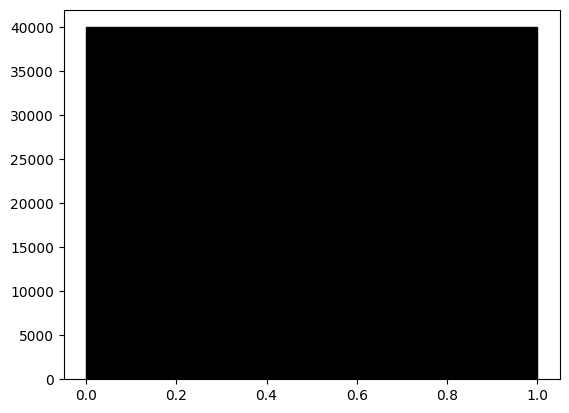

In [15]:
plt.hist(images[0].ravel(), bins=range(2), fc='k', ec='k')# check the distribution of the normalized image

#### 2.3 Split Dataset into train/test partitions

##### Save the labels ( normal or pneumonia) of each image

In [16]:
y=data_df['label'].values

In [17]:
y_labelencoder=LabelEncoder() # one hot encode the labels to facilitate the process 
y=y_labelencoder.fit_transform(y)

##### Split the data set

In [18]:
images,y=shuffle(images,y,random_state=1) # shuffle the images with its label 
train_x,test_x,train_y,test_y = train_test_split(images,y,test_size=0.2, random_state=1)# split the data into train and test partitions
# the testing size will be 5% of the entire data set
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2494, 200, 200)
(624, 200, 200)
(2494,)
(624,)


In [19]:
train_x[0].shape # check the size of 1 single image in the train_x partition

(200, 200)

##### Check the values of the images

(array([40000.,     0.]),
 array([0., 1., 2.]),
 <BarContainer object of 2 artists>)

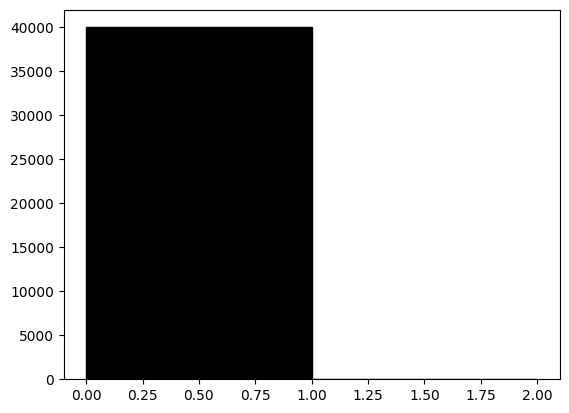

In [20]:
plt.hist(test_x[69].ravel(), bins=range(3), fc='k', ec='k') # check if the images have values on it

##### Flatten the dataset to obtain each pixel as a feature in a single row

In [21]:
train_x_flat = [] # create array
for i in range(len(train_x)): # this will cycle through each image on train_x 
    train_x_flat.append(train_x[i].flatten()) # add the flatten image to the array
train_x_flat = np.array(train_x_flat) # convert it to a numpy array

In [22]:
test_x_flat = []
for i in range(len(test_x)):
    test_x_flat.append(test_x[i].flatten())
test_x_flat = np.array(test_x_flat)

In [23]:
test_x_flat[0].shape

(40000,)

## 3. Create the model

#### 3.1 Define performance metrics 

In [24]:
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1_val

In [25]:
del category,data,data_df,data_count #delete the variables that are not longer needed to free up space

#### 3.2 Tunning

In [26]:
# To avoid OOM errors the tunning is commented ,however it was tested and the recommended values were implemented on the network 

###### 3.2 Tunning

In [27]:
'''def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(im_size, im_size)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=16, max_value=2000, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))
  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))
  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))
  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))
  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))
  model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy',F1_Score])

  return model'''

"def model_builder(hp):\n  model = keras.Sequential()\n  model.add(keras.layers.Flatten(input_shape=(im_size, im_size)))\n\n  # Tune the number of units in the first Dense layer\n  # Choose an optimal value between 32-512\n  hp_units = hp.Int('units', min_value=16, max_value=2000, step=32)\n  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))\n  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))\n  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))\n  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))\n  model.add(keras.layers.Dense(units=hp_units, activation=tf.nn.relu))\n  model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))\n\n  # Tune the learning rate for the optimizer\n  # Choose an optimal value from 0.01, 0.001, or 0.0001\n  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])\n\n  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),\n                loss=k

In [28]:
'''tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=1,
    overwrite=True
)'''

'tuner = kt.RandomSearch(\n    hypermodel=model_builder,\n    objective="val_accuracy",\n    max_trials=15,\n    executions_per_trial=1,\n    overwrite=True\n)'

In [29]:
'''stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)'''


"stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)"

In [30]:
'''tuner.search(train_x,train_y, epochs=10, validation_data=(test_x, test_y), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")'''

'tuner.search(train_x,train_y, epochs=10, validation_data=(test_x, test_y), callbacks=[stop_early])\n\n# Get the optimal hyperparameters\nbest_hps=tuner.get_best_hyperparameters(num_trials=1)[0]\n\nprint(f"""\nThe hyperparameter search is complete. The optimal number of units in the first densely-connected\nlayer is {best_hps.get(\'units\')} and the optimal learning rate for the optimizer\nis {best_hps.get(\'learning_rate\')}.\n""")'

In [31]:
'''model = tuner.hypermodel.build(best_hps)'''

'model = tuner.hypermodel.build(best_hps)'

In [32]:
'''model.summary()'''

'model.summary()'

In [33]:
'''# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_x,train_y, epochs=10, validation_data=(test_x, test_y))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))'''

"# Build the model with the optimal hyperparameters and train it on the data for 10 epochs\nmodel = tuner.hypermodel.build(best_hps)\nhistory = model.fit(train_x,train_y, epochs=10, validation_data=(test_x, test_y))\n\nval_acc_per_epoch = history.history['val_accuracy']\nbest_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1\nprint('Best epoch: %d' % (best_epoch,))"

In [34]:
'''hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_x,train_y, epochs=best_epoch, validation_data=(test_x, test_y))'''

'hypermodel = tuner.hypermodel.build(best_hps)\n\n# Retrain the model\nhypermodel.fit(train_x,train_y, epochs=best_epoch, validation_data=(test_x, test_y))'

In [35]:
'''eval_result = hypermodel.evaluate(test_x, test_y)
print("[test loss, test accuracy]:", eval_result)'''

'eval_result = hypermodel.evaluate(test_x, test_y)\nprint("[test loss, test accuracy]:", eval_result)'

In [36]:
'''# evaluate your model and print the metrics
loss, accuracy, precision, recall, f1_score = hypermodel.evaluate(test_x, test_y, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test F1 score:', f1_score)'''

"# evaluate your model and print the metrics\nloss, accuracy, precision, recall, f1_score = hypermodel.evaluate(test_x, test_y, verbose=0)\nprint('Test loss:', loss)\nprint('Test accuracy:', accuracy)\nprint('Test precision:', precision)\nprint('Test recall:', recall)\nprint('Test F1 score:', f1_score)"

In [37]:
'''models = tuner.results_summary()'''

'models = tuner.results_summary()'

#### 3.3 Define the architecture

In [38]:
model= keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(im_size,im_size)))  #layer 0 always needs the input shape ,
#if trained with train_x size must be (300,300) if trained with train_x_flat size must be (90 000 ,1)

model.add(keras.layers.Dense(720,activation=tf.nn.relu))       # layer 1

model.add(keras.layers.Dense(720,activation=tf.nn.relu))       # layer 2

model.add(keras.layers.Dense(720,activation=tf.nn.relu))       # layer 3

model.add(keras.layers.Dense(720,activation=tf.nn.relu))       # layer 4

model.add(keras.layers.Dense(720,activation=tf.nn.relu))       # layer 5

model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))      # layer 6

In [39]:
model.summary() # confirm the architecture of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 720)               28800720  
                                                                 
 dense_1 (Dense)             (None, 720)               519120    
                                                                 
 dense_2 (Dense)             (None, 720)               519120    
                                                                 
 dense_3 (Dense)             (None, 720)               519120    
                                                                 
 dense_4 (Dense)             (None, 720)               519120    
                                                                 
 dense_5 (Dense)             (None, 1)                 7

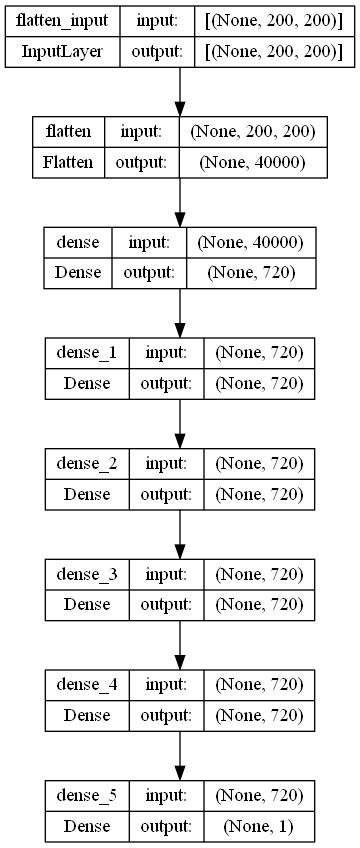

In [40]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True, show_layer_names=True) #Print the architecture as an image 


##### Compile the model 

In [41]:
model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy',F1_Score,tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]) 

## 4. Train the model

#### 4.1 Train the model and set the tensorboard

In [42]:
logdir='logs'
%load_ext tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


hist=model.fit(train_x,train_y, epochs=80,batch_size=150,validation_data=(test_x,test_y)) # first the training data ,next the labes , 
#next how many epochs and what size of batch
# epochs is how many times will the model see the data , batch means how many images per block 
#Always pass the validation data so it generates the val loss to plot later

Epoch 1/80
17/17 [==============================] - 5s 129ms/step - loss: 4.2655 - accuracy: 0.5020 - F1_Score: 0.3677 - recall: 0.5196 - precision: 0.5317 - val_loss: 1.2545 - val_accuracy: 0.4391 - val_F1_Score: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/80
17/17 [==============================] - 1s 78ms/step - loss: 0.7399 - accuracy: 0.6103 - F1_Score: 0.5563 - recall: 0.6586 - precision: 0.6264 - val_loss: 0.6155 - val_accuracy: 0.6202 - val_F1_Score: 0.5343 - val_recall: 0.3514 - val_precision: 0.9248
Epoch 3/80
17/17 [==============================] - 1s 78ms/step - loss: 0.5784 - accuracy: 0.6889 - F1_Score: 0.6816 - recall: 0.7236 - precision: 0.7003 - val_loss: 0.4074 - val_accuracy: 0.8061 - val_F1_Score: 0.8280 - val_recall: 0.7857 - val_precision: 0.8567
Epoch 4/80
17/17 [==============================] - 1s 80ms/step - loss: 0.4594 - accuracy: 0.7943 - F1_Score: 0.7961 - recall: 0.7885 - precision: 0.8175 - val_loss: 0.5289 - val_accuracy: 0.

#### 4.2 Evaluation Metrics

##### 4.2.1 Train set metrics

In [43]:
# evaluate your model and print the metrics
loss, accuracy, precision, recall, f1_score = model.evaluate(train_x, train_y, verbose=0)
print('Train loss:', loss)
print('Train accuracy:', accuracy)
print('Train precision:', precision)
print('Train recall:', recall)
print('Train F1 score:', f1_score)

Train loss: 0.21219664812088013
Train accuracy: 0.9065757989883423
Train precision: 0.9006173610687256
Train recall: 0.8413897156715393
Train F1 score: 0.9797713160514832


##### 4.2.2 Test set metrics

In [44]:
# evaluate your model and print the metrics
loss, accuracy, precision, recall, f1_score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test F1 score:', f1_score)

Test loss: 0.3432628810405731
Test accuracy: 0.8717948794364929
Test precision: 0.86927729845047
Test recall: 0.7914285659790039
Test F1 score: 0.9753521084785461


##### 4.2.3 Performance graphs

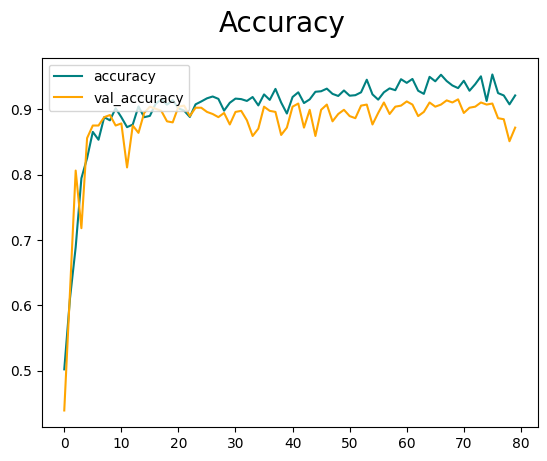

In [45]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

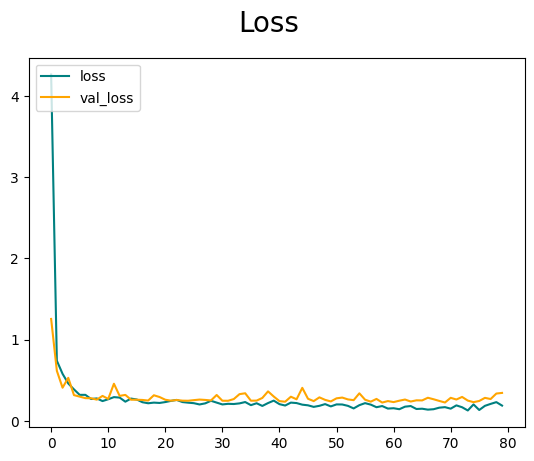

In [46]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

F1 SCORE

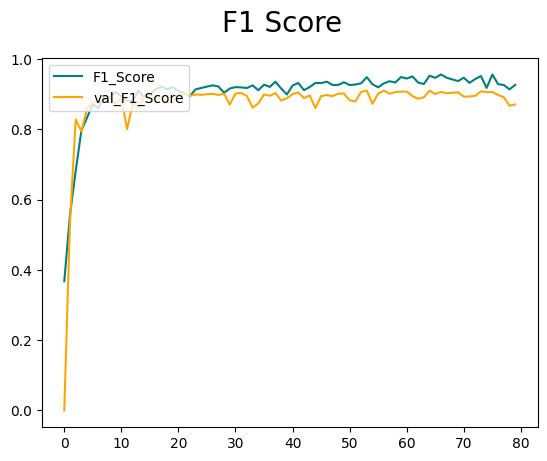

In [47]:
fig = plt.figure()
plt.plot(hist.history['F1_Score'], color='teal', label='F1_Score')
plt.plot(hist.history['val_F1_Score'], color='orange', label='val_F1_Score')
fig.suptitle('F1 Score', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### 4.2.4 5-CV

In [48]:
# define the number of folds for cross-validation
num_folds = 5

# initialize the KFold class
kf = KFold(n_splits=num_folds)

# initialize a list to store the evaluation metrics for each fold
fold_metrics = []

# loop over the folds
for fold, (train_index, val_index) in enumerate(kf.split(images)):
    
    # split the dataset into train and validation sets for this fold
    X_train, y_train = images[train_index], y[train_index]
    X_val, y_val = images[val_index], y[val_index]
    
    # train the model on the train set for this fold
    model.fit(X_train, y_train)
    
    # evaluate the model on the validation set for this fold
    metrics = model.evaluate(X_val, y_val)
    
    # store the evaluation metrics for this fold
    fold_metrics.append(metrics)
    
    # reset the model weights for the next fold
    model.reset_states()

# print the average evaluation metrics across all folds
mean_metrics = np.mean(fold_metrics, axis=0)
print("Mean metrics: ", mean_metrics)

20/20 [==============================] - 0s 21ms/step - loss: 0.1961 - accuracy: 0.9310 - F1_Score: 0.9292 - recall: 0.9226 - precision: 0.9430
Mean metrics:  [0.2298385  0.90829321 0.9048141  0.86348935 0.96342192]


In [49]:
del images

## 5. Set up variables for interpretation

#### 5.1 Get the weights and biases of the model 

In [50]:
# Each variabe will contain a list containing two attributes 0 weights and 1 biases
layer_0=model.layers[0].get_weights() # layer 0 will contain no weights as it is just the entry of data 
layer_1=model.layers[1].get_weights()
layer_2=model.layers[2].get_weights()
layer_3=model.layers[3].get_weights()
layer_4=model.layers[4].get_weights()
layer_5=model.layers[5].get_weights()
layer_6=model.layers[6].get_weights()

In [51]:
print("Weights of layer 1: ",layer_1[0].shape) # weights
print("Biases of layer  1: ",layer_1[1].shape) # biases
print("Weights of layer 2: ",layer_2[0].shape) # weights
print("Biases of layer  2: ",layer_2[1].shape) # biases
print("Weights of layer 3: ",layer_3[0].shape) # weights
print("Biases of layer  3: ",layer_3[1].shape) # biases
print("Weights of layer 4: ",layer_4[0].shape) # weights
print("Biases of layer  4: ",layer_4[1].shape) # biases
print("Weights of layer 5: ",layer_5[0].shape) # weights
print("Biases of layer  5: ",layer_5[1].shape) # biases
print("Weights of layer 6: ",layer_6[0].shape) # weights
print("Biases of layer  6: ",layer_6[1].shape) # biases

Weights of layer 1:  (40000, 720)
Biases of layer  1:  (720,)
Weights of layer 2:  (720, 720)
Biases of layer  2:  (720,)
Weights of layer 3:  (720, 720)
Biases of layer  3:  (720,)
Weights of layer 4:  (720, 720)
Biases of layer  4:  (720,)
Weights of layer 5:  (720, 720)
Biases of layer  5:  (720,)
Weights of layer 6:  (720, 1)
Biases of layer  6:  (1,)


#### 5.2 Group all weights into a single array and biases into a different array

In [52]:
w_list, b_list = [layer_1[0], layer_2[0],layer_3[0],layer_4[0],layer_5[0],layer_6[0]], [layer_1[1],layer_2[1],layer_3[1],layer_4[1],layer_5[1],layer_6[1]]

In [53]:
len(w_list) # confirm that w list has 5 items 

6

#### 5.3 Image number variable

In [54]:
test_number=87 # Select a number to test an image , the number can be from 0-156

#### 5.4 Predict label of the image

In [55]:
y_hat=model.predict(np.expand_dims((test_x[test_number]),0))

if y_hat > 0.5: 
     pred_label='Pneumonia'
     y_hat=1
else:
     pred_label='Normal'
     y_hat=0
print(pred_label)
print("The final value of neuron was:",y_hat)
print(f'Predicted class is : ',pred_label)
real_label=test_y[test_number]
if y_hat==real_label :
     print("The model is correct")
else:
     print("The model is wrong")

1/1 [==============================] - 0s 429ms/step
Normal
The final value of neuron was: 0
Predicted class is :  Normal
The model is correct


Text(0.5, 1.0, 'Normal Image number: 87')

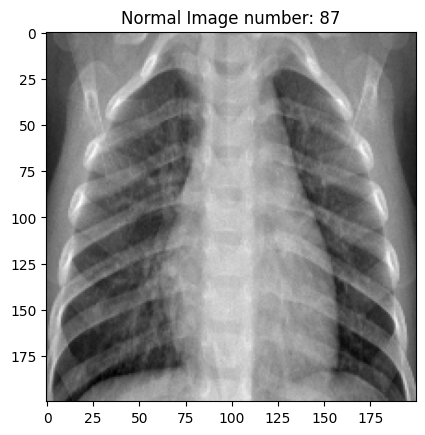

In [56]:
plt.imshow((test_x[test_number]),cmap = plt.cm.gray)# plot image on training set 
plt.title(pred_label+" Image number: "+str(test_number))

## 6. Aletheia

#### 6.1 Aletheia Global

##### 6.1.1 Aletheia Global set up

In [57]:
clf=UnwrapperClassifier(w_list,b_list)
clf.fit(test_x_flat,test_y )
clf.summary()

C:\Users\rony_\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\rony_\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Count  Response Mean  Response Std  Local AUC  Global AUC
0      8.0            0.0           0.0        NaN    0.957487
1      5.0            0.0           0.0        NaN    0.957591
2      4.0            0.0           0.0        NaN    0.957466
3      4.0            1.0           0.0        NaN    0.964724
4      3.0            0.0           0.0        NaN    0.956976
..     ...            ...           ...        ...         ...
569    1.0            1.0           NaN        NaN    0.969802
570    1.0            1.0           NaN        NaN    0.966382
571    1.0            1.0           NaN        NaN    0.967862
572    1.0            0.0           NaN        NaN    0.957810
573    1.0            1.0           NaN        NaN    0.968060

[574 rows x 5 columns]

In [58]:
aletheia_image=clf.all_weights# call the weights of the network
print(aletheia_image.shape)# it should be the number of images (157) ,the size of the flatten image 40,000
#Scale all the weights of the network so they will be plotted on the same scale
scaler = MinMaxScaler(feature_range=(0, 100))# scale the obtained weights from 0-100 range
scaler.fit(aletheia_image)
scaled_data = scaler.transform(aletheia_image)
#Select one single image
aletheia_image=scaled_data[test_number]
print(aletheia_image.shape)
#aletheia_image=clf.all_weights[test_number]#uncomment to do without scaling
#reshape the array into the image size
aletheia_image=aletheia_image.reshape(im_size,im_size)

(574, 40000)
(40000,)


##### 6.1.2 Global Aletheia plot

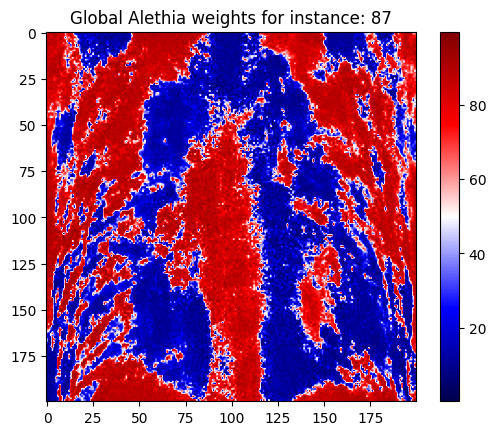

In [59]:
plt.imshow(aletheia_image, cmap='seismic')
plt.colorbar()
plt.title("Global Alethia weights for instance: "+str(test_number))
plt.show()


##### 6.1.3 Global Aletheia and the original image plot

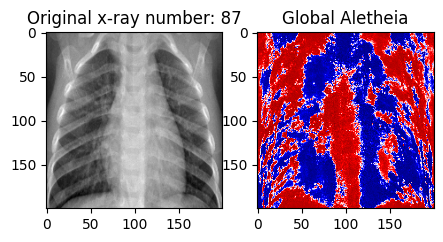

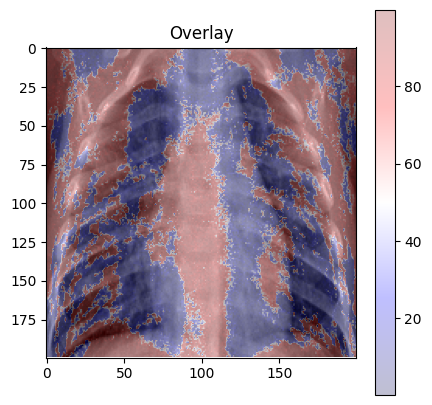

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))


ax1.imshow(test_x[test_number],cmap=plt.cm.gray)
ax1.set_title('Original x-ray'+" number: "+str(test_number))

# Plot the second image on the second subplot
ax2.imshow(aletheia_image, cmap ='seismic')

ax2.set_title('Global Aletheia')


# Show the plot
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plt.imshow(aletheia_image, cmap ='seismic', alpha=0.25)
plt.colorbar()
plt.title('Overlay')
plt.show()

#### 6.2 Aletheia local unwrapper

##### 6.2.1 Aletheia local set up

In [61]:
#Select a single instance of the test set 
aletheia_single=test_x_flat[test_number] #Create a new dataframe with just one image

aletheia_single=aletheia_single.reshape(1, -1)# reduce dimentionality 

aletheia_single_y=np.array([test_y[test_number]])#Save the label of the selected image

print("_______________")
print("Shape of aletheia single")
print(aletheia_single.shape)
print("_______________")
print("Shape of aletheia single_y")
print(aletheia_single_y.shape)
print("_______________")
print("The following 2 numbers must be the same")
print(test_y[test_number])
print(aletheia_single_y)

_______________
Shape of aletheia single
(1, 40000)
_______________
Shape of aletheia single_y
(1,)
_______________
The following 2 numbers must be the same
0
[0]


In [62]:
clf2=UnwrapperClassifier(w_list,b_list)
clf2.fit(aletheia_single,aletheia_single_y)
clf2.summary()
 # Select a number to test an image , the number can be from 0-156
aletheia_local_image=clf2.all_weights# call the weights of the network
print(aletheia_local_image.shape)# it should be the number of images (157) ,the size of the flatten image 40,000
#Scale all the weights of the network so they will be plotted on the same scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(aletheia_local_image)
scaled_data = scaler.transform(aletheia_local_image)
#Select one single image
aletheia_local_image=scaled_data[0]
#aletheia_local_image=clf2.all_weights[0]#uncomment to undo the scaling 
print(aletheia_local_image.shape)
#reshape the array into the image size
aletheia_local_image=aletheia_local_image.reshape(im_size,im_size)

C:\Users\rony_\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\rony_\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(1, 40000)
(40000,)


##### 6.2.2 Local aletheia plot

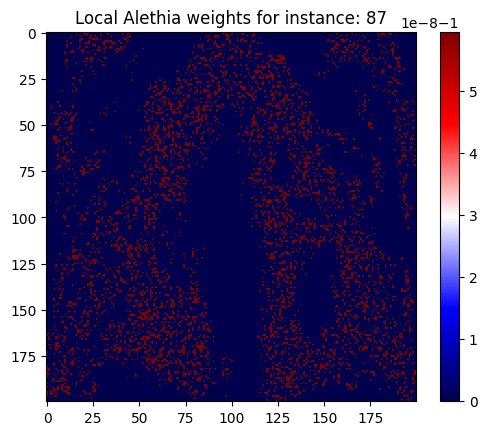

In [63]:
plt.imshow(aletheia_local_image, cmap='seismic')
plt.colorbar()
plt.title("Local Alethia weights for instance: "+str(test_number))
plt.show()

##### 6.2.3 Local Aletheia and the original image plot

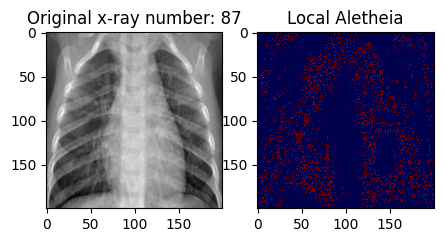

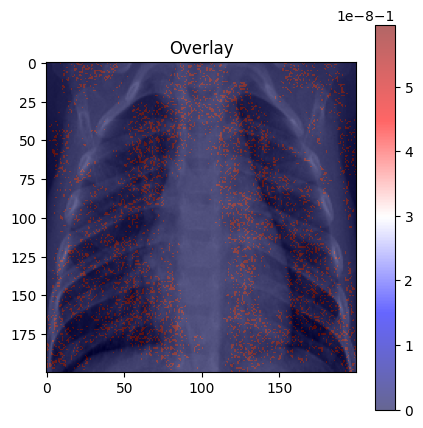

In [64]:
#### Aletheia and the original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))


ax1.imshow(test_x[test_number],cmap=plt.cm.gray)
ax1.set_title('Original x-ray'+" number: "+str(test_number))

# Plot the second image on the second subplot
ax2.imshow(aletheia_local_image, cmap ='seismic')

ax2.set_title('Local Aletheia')


# Show the plot
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plt.imshow(aletheia_local_image, cmap ='seismic', alpha=0.6)
plt.colorbar()
plt.title('Overlay')
plt.show()
#### Local vs Global vs Aletheia vs Local Aletheia

# Show the plot
plt.show()

## 7. Unwrapper

#### 7.1 Global unwrapper

##### 7.1.1 Set up the Global unwrapper

In [65]:
global_feature_weights, global_intercepts = {}, {} # create dictionary that will contain global weights and biases
layers = range(len(w_list)) # create a range  based on how many items the weights list contains in this case 0-5 
iterator_range = range(test_x_flat.shape[0]) # iterable range is how many images are in the dataset 
iterable = test_x_flat # iterable is the dataset in which is trained 
for i in iterator_range: # it will cycle through each image on the training set in this case 157
    print(i," of ",iterator_range) # this line is just to check progress
    layer_j = np.copy(iterable[i])# copy a single instance in the form of array
    global_activation_pattern = []
    for j in layers:              # will cycle from 0-5
        if j == len(w_list) - 1:  # will execute when j reaches 4 
            continue
        layer_j = layer_j @ w_list[j] + b_list[j] # will multiply the single instance array with the weights corresponding to that instance after that will add the biases of that instance      
        layer_j[layer_j <= 0] = 0 # if the value of layer_j is negative it will assign 0 value
        global_activation_pattern.extend(np.where(layer_j > 0)) # add the layer j to the activation pattern only when it is a positive value
    for j in layers:  #will cycle from 0-5 
        if j == 0:    # will execute only on the first run 
            global_feature_weights_layer = w_list[j][:,global_activation_pattern[j]] 
            global_intercepts_layer = b_list[j][global_activation_pattern[j]]
        elif j > 0 and j < len(w_list) - 1: # will execute from 1 through 3 
            layer_j_w_active_input = w_list[j][global_activation_pattern[j-1],:]
            layer_j_w_active_output = layer_j_w_active_input[:,global_activation_pattern[j]]
            global_feature_weights_layer = global_feature_weights_layer @ layer_j_w_active_output
            global_intercepts_layer = global_intercepts_layer @ layer_j_w_active_output + b_list[j][global_activation_pattern[j]]
        elif j == len(w_list) - 1: # will execute on the last run 
            layer_j_w_active_input = w_list[j][global_activation_pattern[j-1],:]
            global_feature_weights_layer = global_feature_weights_layer @ layer_j_w_active_input
            global_intercepts_layer = global_intercepts_layer @ layer_j_w_active_input + b_list[j]
    global_feature_weights[i], global_intercepts[i] = global_feature_weights_layer, global_intercepts_layer

0  of  range(0, 624)
1  of  range(0, 624)
2  of  range(0, 624)
3  of  range(0, 624)
4  of  range(0, 624)
5  of  range(0, 624)
6  of  range(0, 624)
7  of  range(0, 624)
8  of  range(0, 624)
9  of  range(0, 624)
10  of  range(0, 624)
11  of  range(0, 624)
12  of  range(0, 624)
13  of  range(0, 624)
14  of  range(0, 624)
15  of  range(0, 624)
16  of  range(0, 624)
17  of  range(0, 624)
18  of  range(0, 624)
19  of  range(0, 624)
20  of  range(0, 624)
21  of  range(0, 624)
22  of  range(0, 624)
23  of  range(0, 624)
24  of  range(0, 624)
25  of  range(0, 624)
26  of  range(0, 624)
27  of  range(0, 624)
28  of  range(0, 624)
29  of  range(0, 624)
30  of  range(0, 624)
31  of  range(0, 624)
32  of  range(0, 624)
33  of  range(0, 624)
34  of  range(0, 624)
35  of  range(0, 624)
36  of  range(0, 624)
37  of  range(0, 624)
38  of  range(0, 624)
39  of  range(0, 624)
40  of  range(0, 624)
41  of  range(0, 624)
42  of  range(0, 624)
43  of  range(0, 624)
44  of  range(0, 624)
45  of  range(0, 624

In [66]:
#Convert the feature weights from a dictionary to a numpy array 
weights_array = np.array(list(global_feature_weights.values()))
print("The shape of the weights array is:")
print(weights_array.shape)
#Reshape the array and reduce dimentionality , first value is the number of instances , the second value (-1) means that the second 
# and third value will be multiplied
new_shape = (624, -1)# the new shape should be the number of instances on the test partition and the total features (im_sizexim_size)
weights_array=weights_array.reshape(new_shape)
print("-----------------------------")
print("The new shape of the weights array is")
print(weights_array.shape)
#Scale the weights so they can be plotted on the same scale
scaler = MinMaxScaler(feature_range=(0, 100))
scaler.fit(weights_array)
scaled_data = scaler.transform(weights_array)
print("-----------------------------")
unwrapper_image=scaled_data[test_number]
#unwrapper_image=weights_array[test_number]#Uncomment this line to avoid the normalization
print("Image shape:")
print(unwrapper_image.shape)
unwrapper_image=unwrapper_image.reshape(im_size,im_size)
print("-----------------------------")
print("Image shape after reshape:")
print(unwrapper_image.shape)

The shape of the weights array is:
(624, 40000, 1)
-----------------------------
The new shape of the weights array is
(624, 40000)
-----------------------------
Image shape:
(40000,)
-----------------------------
Image shape after reshape:
(200, 200)


##### 7.1.2 Global unwrapper plot

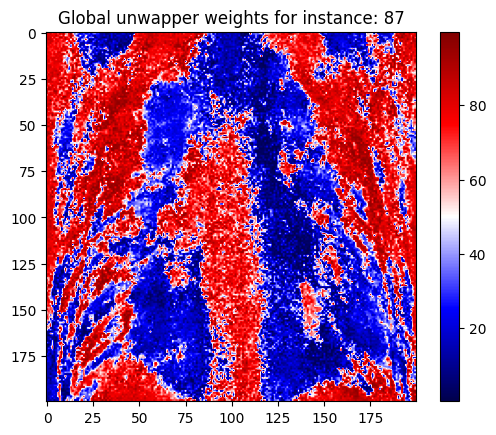

In [67]:
plt.imshow(unwrapper_image, cmap='seismic')
plt.colorbar()
plt.title("Global unwapper weights for instance: "+str(test_number))
plt.show()

##### 7.1.3 Global unwrapper and original image plot 

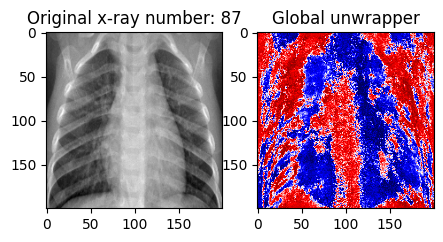

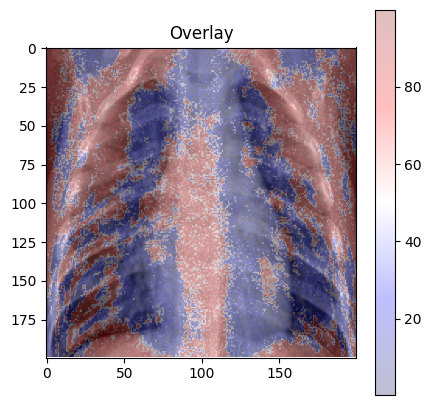

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))


ax1.imshow(test_x[test_number],cmap=plt.cm.gray)
ax1.set_title('Original x-ray'+" number: "+str(test_number))

# Plot the second image on the second subplot
ax2.imshow(unwrapper_image, cmap ='seismic')

ax2.set_title('Global unwrapper')


# Show the plot
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plt.imshow(unwrapper_image, cmap ='seismic', alpha=0.25)
plt.colorbar()
plt.title('Overlay')
plt.show()

#### 7.2 Local Unwrapper

In [69]:
# single image
#test_number=13 # number of the sample that want to test on the local unwrapper uncomment to update the variable from this point 
#This number can be  0-157

##### 7.2.1 Set up the Local unwrapper

In [70]:
local_feature_weights, intercepts = {}, {} # create dictionary that will contain global weights and biases
layers = range(len(w_list)) # create a range  based on how many items the weights list contains in this case 0-5 
iterator_range = range(test_number,(test_number+1)) # iterable range in this case is what single instance of the dataset we want to inspect, the range will be from the testn number to testn number plus one
iterable = test_x_flat# iterable is the dataset in this case can be "test_x_flat"  
w_list=w_list
for i in iterator_range: # it will cycle through each image on the testing set in this case 157
    print(iterable[i],i)
    layer_j = np.copy(iterable[i])# copy a single instance in the form of array
    activation_pattern = []
    for j in layers:              # will cycle from 0-5
        if j == len(w_list) - 1:  # will execute when j reaches 4 
            continue
        layer_j = (layer_j @ w_list[j])+ b_list[j] # will multiply the single instance array with the weights corresponding to that instance after that will add the biases of that instance      
        layer_j[layer_j <= 0] = 0 # if the value of layer_j is negative it will assign 0 value
        activation_pattern.extend(np.where(layer_j > 0)) # add the layer j to the activation pattern only when it is a positive value
    for j in layers:  #will cycle from 0-5 
        if j == 0:    # will execute only on the first run 
            feature_weights_layer = w_list[j][:,activation_pattern[j]] 
            intercepts_layer = b_list[j][activation_pattern[j]]
        elif j > 0 and j < len(w_list) - 1: # will execute from 1 through 3 
            layer_j_w_active_input = w_list[j][activation_pattern[j-1],:]
            layer_j_w_active_output = layer_j_w_active_input[:,activation_pattern[j]]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_output
            intercepts_layer = intercepts_layer @ layer_j_w_active_output + b_list[j][activation_pattern[j]]
        elif j == len(w_list) - 1: # will execute on the last run 
            layer_j_w_active_input = w_list[j][activation_pattern[j-1],:]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_input
            intercepts_layer = intercepts_layer @ layer_j_w_active_input + b_list[j]
    local_feature_weights[i], intercepts[i] = feature_weights_layer, intercepts_layer

[0.3254902  0.3372549  0.32941176 ... 0.56078431 0.52156863 0.56470588] 87


In [71]:
#Convert the feature weights from a dictionary to a numpy array 
local_weights_array = np.array(list(local_feature_weights.values()))
#Reshape the array and reduce dimentionality , first value is the number of instances , the second value (-1) means that the second 
# and third value will be multiplied
print("-----------------------------")
print("The shape of the local weights array is")
print(local_weights_array.shape)
new_shape = (1, -1)
local_weights_array=local_weights_array.reshape(new_shape)
print("-----------------------------")
print("The new shape of the local weights array is")
print(local_weights_array.shape)
#Scale the weights so they can be plotted on the same scale
min_value=weights_array.min()#Obtain the min value inside the weights
max_value=weights_array.max()#Obtain the mas value inside the weights
#scaler = MinMaxScaler(feature_range=(min_value, max_value))# I dont know why this range but they seem to work
scaler = MinMaxScaler(feature_range=(-1, 1))# I dont know why this range but they seem to work
scaler.fit(local_weights_array)
scaled_data = scaler.transform(local_weights_array)
print("-----------------------------")
print("Size of the data: ")
local_unwrapper_image=scaled_data[0]#This number will always be 0 as there is no other instance in the array
print(local_unwrapper_image.shape)
#local_unwrapper_image=local_feature_weights[test_number] #uncomment if want to try the unwrapper without normalization of the weights
local_unwrapper_image=local_unwrapper_image.reshape(im_size,im_size)
print("-----------------------------")
print("Image shape after reshape:")
print(local_unwrapper_image.shape)

-----------------------------
The shape of the local weights array is
(1, 40000, 1)
-----------------------------
The new shape of the local weights array is
(1, 40000)
-----------------------------
Size of the data: 
(40000,)
-----------------------------
Image shape after reshape:
(200, 200)


##### 7.2.2 Local unwrapper plot

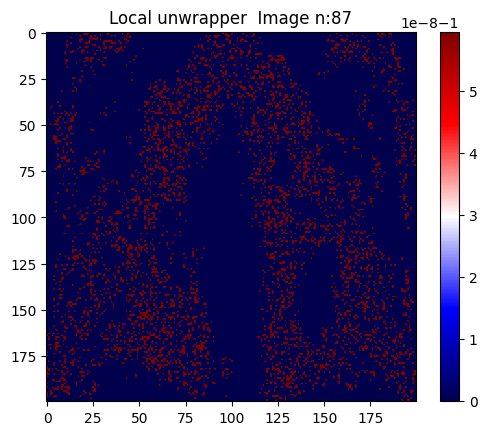

In [72]:
plt.imshow(local_unwrapper_image, cmap='seismic')
plt.colorbar()
plt.title("Local unwrapper "+" Image n:"+str(test_number))
plt.show()

##### 7.2.3 Local unwrapper and original image plot

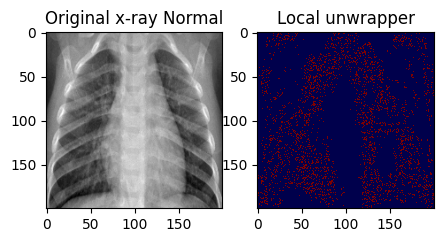

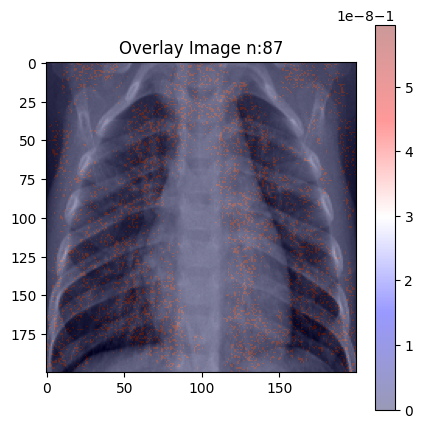

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))

ax1.imshow(test_x[test_number],cmap=plt.cm.gray)
ax1.set_title('Original x-ray '+pred_label)

# Plot the second image on the second subplot
ax2.imshow(local_unwrapper_image, cmap ='seismic')

ax2.set_title('Local unwrapper')

# Show the plot
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plt.imshow(local_unwrapper_image, cmap ='seismic', alpha=0.4)
plt.colorbar()
plt.title('Overlay'+" Image n:"+str(test_number))
plt.show()


## 8. Aletheia vs Unwrapper

#### 8.1 Global

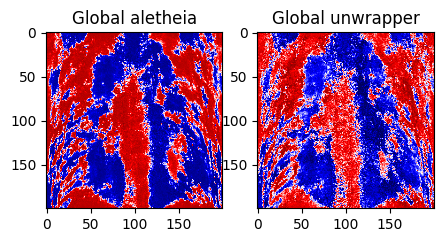

This is for image number:  87


In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))


ax1.imshow(aletheia_image,cmap='seismic')
ax1.set_title('Global aletheia')

# Plot the second image on the second subplot
ax2.imshow(unwrapper_image, cmap ='seismic')

ax2.set_title('Global unwrapper')


# Show the plot
plt.show()
print("This is for image number: ",str(test_number))


#### 8.2 Local

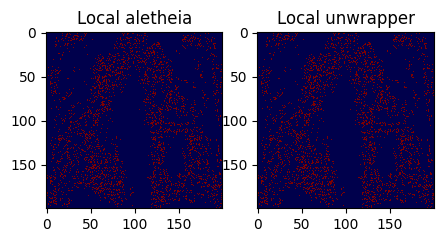

This is for image number:  87


In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))


ax1.imshow(aletheia_local_image,cmap='seismic')
ax1.set_title('Local aletheia')

# Plot the second image on the second subplot
ax2.imshow(local_unwrapper_image, cmap ='seismic')

ax2.set_title('Local unwrapper')


# Show the plot
plt.show()
print("This is for image number: ",str(test_number))

#### 8.3 Local vs Global 

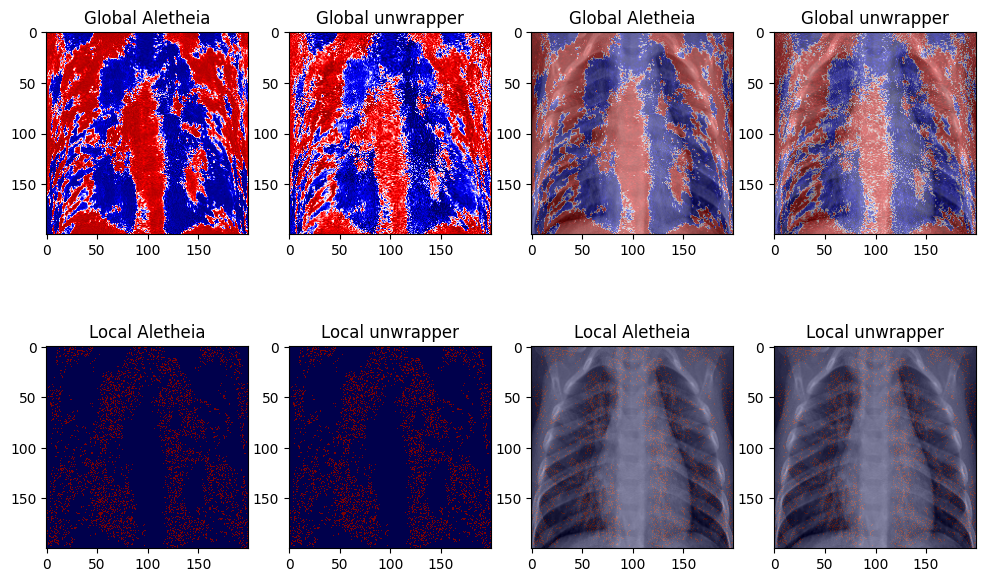

This is for image number:  87


In [76]:
fig, plotarr = plt.subplots(2, 4, figsize=(12,12))
# Plot the global aletheia  image on the 1 subplot
plotarr[0,0].imshow(aletheia_image,cmap='seismic')
plotarr[0,0].set_title('Global Aletheia')

# Plot the global unwrapper image on the 2 subplot
plotarr[0,1].imshow(unwrapper_image, cmap ='seismic')
plotarr[0,1].set_title('Global unwrapper')

# Plot the overlay image of global aletheia on the 3 subplot
plotarr[0,2].imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plotarr[0,2].imshow(aletheia_image, cmap ='seismic', alpha=0.4)
plotarr[0,2].set_title('Global Aletheia')

# Plot the overlay image of global unwrapper on the 4 subplot
plotarr[0,3].imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plotarr[0,3].imshow(unwrapper_image, cmap ='seismic', alpha=0.4)
plotarr[0,3].set_title('Global unwrapper')


# Plot the Local aletheia image on the 5 subplot
plotarr[1,0].imshow(aletheia_local_image, cmap ='seismic')
plotarr[1,0].set_title('Local Aletheia')

# Plot the Local unwrapper image on the 6 subplot
plotarr[1,1].imshow(local_unwrapper_image, cmap ='seismic')
plotarr[1,1].set_title('Local unwrapper')

# Plot the overlay image of local alethia on the 7 subplot
plotarr[1,2].imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plotarr[1,2].imshow(aletheia_local_image, cmap ='seismic', alpha=0.4)
plotarr[1,2].set_title('Local Aletheia')

# Plot the overlay image of local unwrapper on the 7 subplot
plotarr[1,3].imshow(test_x[test_number],cmap=plt.cm.gray,alpha=1)
plotarr[1,3].imshow(local_unwrapper_image, cmap ='seismic', alpha=0.4)
plotarr[1,3].set_title('Local unwrapper')



# Show the plot
plt.subplots_adjust(wspace=0.2,bottom=0.4)



plt.show()
print("This is for image number: ",str(test_number))
#+" Image n:"+str(test_number)

## 9. Test an unseen image

#### 9.1 Preprocess the image

In [77]:
# Prepare the image as we prepared the training data 
images_test=[]
img_test=cv2.imread("pneumonia2.jpeg",cv2.IMREAD_GRAYSCALE) # open the image as a grayscale image meaning just one channel instead of 3
img_test=cv2.resize(img_test,(im_size,im_size)) #resize the image to the selected size
images_test.append(img_test)  # add the image to an array
images_test=np.array(images_test)
images_test=((images_test)/255) #normalize the image
test_new=0#This variable will always be 0

##### Flatten the image to use it in the unwrapper

In [78]:
images_test_flat = [] # create array
for i in range(len(images_test)): # this will cycle through each image on train_x 
    images_test_flat.append(images_test[i].flatten()) # add the flatten image to the array
images_test_flat = np.array(images_test_flat) # convert it to a numpy array

##### Predict with the model to check the label

In [79]:
y_pred=model.predict(images_test)
y_pred
if y_pred > 0.5: 
     pred_label_new='Pneumonia'
     y_pred=1
else:
     pred_label_new='Normal'
     y_pred=0
print(pred_label_new)
print("The final value of neuron was:",y_pred)
print(f'Predicted class is : ',pred_label_new)

1/1 [==============================] - 0s 53ms/step
Pneumonia
The final value of neuron was: 1
Predicted class is :  Pneumonia


Text(0.5, 1.0, 'Pneumonia')

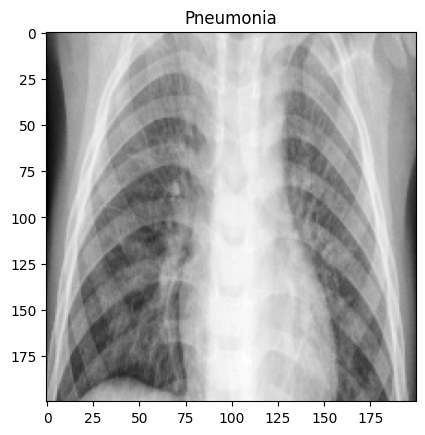

In [80]:
plt.imshow((images_test[test_new]),cmap = plt.cm.gray)# plot image 0 on training set 
plt.title(pred_label_new)


###### Obtain the weights again? 

In [81]:
# Each variabe will contain a list containing two attributes 0 weights and 1 biases
layer_0=model.layers[0].get_weights() # layer 0 will contain no weights as it is just the entry of data 
layer_1=model.layers[1].get_weights()
layer_2=model.layers[2].get_weights()
layer_3=model.layers[3].get_weights()
layer_4=model.layers[4].get_weights()
layer_5=model.layers[5].get_weights()


#### 9.2 local unwrapper

##### 9.2.0 Set up Local unwapper

In [82]:
# single image
test_new=0 # number of the sample that want to test on the local unwrapper when testing new image will always be 0

new_feature_weights, intercepts = {}, {} # create dictionary that will contain global weights and biases
layers = range(len(w_list)) # create a range  based on how many items the weights list contains in this case 0-5 
iterator_range = range(test_new,(test_new+1)) # iterable range in this case is what single instance of the dataset we want to inspect, the range will be from the testn number to testn number plus one
iterable = images_test_flat# iterable is the dataset in this case can be "images_test_flat"  
for i in iterator_range: # it will cycle through each image on the testing set in this case 1
    print(iterable[i],i)
    layer_j = np.copy(iterable[i])# copy a single instance in the form of array
    activation_pattern = []
    for j in layers:              # will cycle from 0-5
        if j == len(w_list) - 1:  # will execute when j reaches 4 
            continue
        layer_j = layer_j @ w_list[j] + b_list[j] # will multiply the single instance array with the weights corresponding to that instance after that will add the biases of that instance      
        layer_j[layer_j <= 0] = 0 # if the value of layer_j is negative it will assign 0 value
        activation_pattern.extend(np.where(layer_j > 0)) # add the layer j to the activation pattern only when it is a positive value
    for j in layers:  #will cycle from 0-5 
        if j == 0:    # will execute only on the first run 
            feature_weights_layer = w_list[j][:,activation_pattern[j]] 
            intercepts_layer = b_list[j][activation_pattern[j]]
        elif j > 0 and j < len(w_list) - 1: # will execute from 1 through 3 
            layer_j_w_active_input = w_list[j][activation_pattern[j-1],:]
            layer_j_w_active_output = layer_j_w_active_input[:,activation_pattern[j]]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_output
            intercepts_layer = intercepts_layer @ layer_j_w_active_output + b_list[j][activation_pattern[j]]
        elif j == len(w_list) - 1: # will execute on the last run 
            layer_j_w_active_input = w_list[j][activation_pattern[j-1],:]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_input
            intercepts_layer = intercepts_layer @ layer_j_w_active_input + b_list[j]
new_feature_weights[i], intercepts[i] = feature_weights_layer, intercepts_layer



[0.22745098 0.25882353 0.2745098  ... 0.34117647 0.29411765 0.22352941] 0


##### 9.2.1 Local unwrapper plot

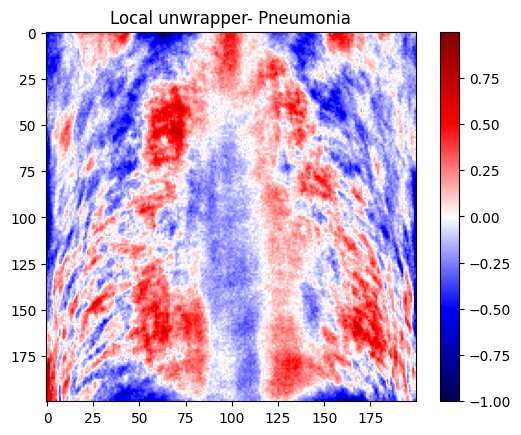

In [83]:
pred_image=new_feature_weights[test_new] # generate the weighted sum of the weights and biases
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(pred_image)
scaled_data = scaler.transform(pred_image)
pred_image=scaled_data

#pred_image=new_feature_weights[test_new]#uncomment to undo scaling
pred_image=pred_image.reshape(im_size,im_size)
###### Heat map 
plt.imshow(pred_image, cmap='seismic')
plt.colorbar()
plt.title("Local unwrapper- "+pred_label_new)
plt.show()

##### 9.2.2 Local unwrapper and original image plot

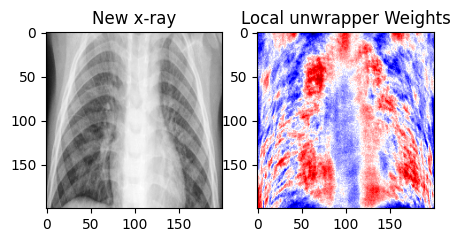

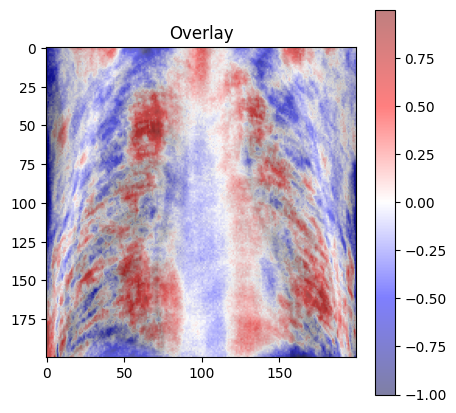

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))


ax1.imshow(images_test[test_new],cmap=plt.cm.gray)
ax1.set_title('New x-ray')

# Plot the second image on the second subplot
ax2.imshow(pred_image, cmap ='seismic')

ax2.set_title('Local unwrapper Weights')


# Show the plot
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(images_test[test_new],cmap=plt.cm.gray,alpha=1)
plt.imshow(pred_image, cmap ='seismic', alpha=0.5)
plt.colorbar()
plt.title('Overlay')
plt.show()


#### 9.3 Local Aletheia

##### 9.3.0 Set up  Local aletheia

In [85]:
#Select a single instance of the test set 
new_aletheia_single=images_test_flat[test_new] #Create a new dataframe with just one image

new_aletheia_single=new_aletheia_single.reshape(1, -1)# reduce dimentionality 

new_aletheia_single_y=np.array([y_pred])#Save the label of the selected image

print("_______________")
print("Shape of aletheia single")
print(aletheia_single.shape)
print("_______________")
print("Shape of aletheia single_y")
print(aletheia_single_y.shape)
print("_______________")
print("The following 2 numbers must be the same")
print(y_pred)
print(new_aletheia_single_y)

_______________
Shape of aletheia single
(1, 40000)
_______________
Shape of aletheia single_y
(1,)
_______________
The following 2 numbers must be the same
1
[1]


In [86]:
clf3=UnwrapperClassifier(w_list,b_list)
clf3.fit(new_aletheia_single,new_aletheia_single_y)
clf3.summary()
 # Select a number to test an image , the number can be from 0-156
new_aletheia_local_image=clf3.all_weights# call the weights of the network
print(new_aletheia_local_image.shape)# it should be the number of images (157) ,the size of the flatten image 40,000
#Scale all the weights of the network so they will be plotted on the same scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(new_aletheia_local_image)
scaled_data = scaler.transform(new_aletheia_local_image)
#Select one single image
new_aletheia_local_image=scaled_data[0]
#new_aletheia_local_image=clf3.all_weights[0]#uncomment to undo the scaling 
print(new_aletheia_local_image.shape)
#reshape the array into the image size
new_aletheia_local_image=new_aletheia_local_image.reshape(im_size,im_size)

C:\Users\rony_\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\rony_\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(1, 40000)
(40000,)


##### 9.3.1 Local Aletheia plot

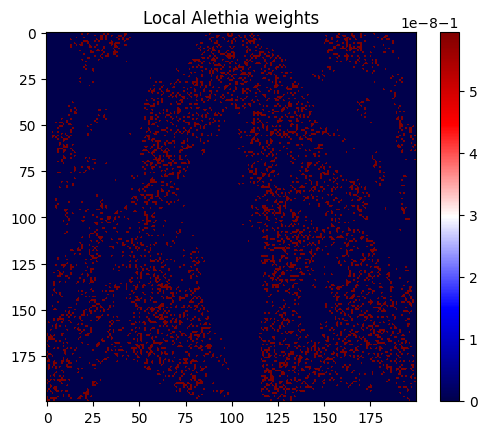

In [87]:
plt.imshow(new_aletheia_local_image, cmap='seismic')
plt.colorbar()
plt.title("Local Alethia weights")
plt.show()

##### 9.3.2 Local Aletheia and original image

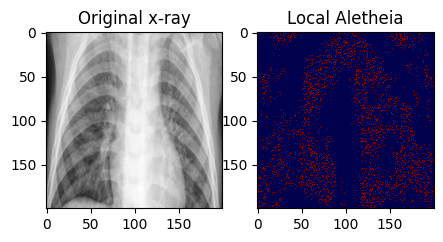

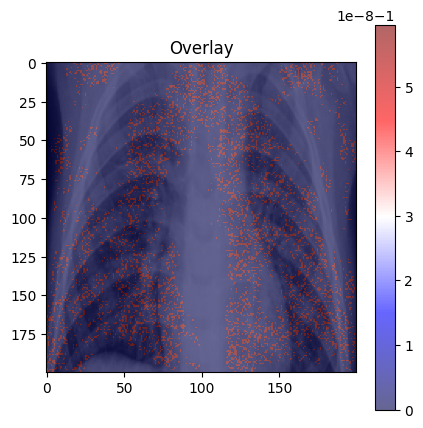

In [88]:
#### Aletheia and the original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))


ax1.imshow(images_test[test_new],cmap=plt.cm.gray)
ax1.set_title('Original x-ray')

# Plot the second image on the second subplot
ax2.imshow(new_aletheia_local_image, cmap ='seismic')

ax2.set_title('Local Aletheia')


# Show the plot
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(images_test[test_new],cmap=plt.cm.gray,alpha=1)
plt.imshow(new_aletheia_local_image, cmap ='seismic', alpha=0.6)
plt.colorbar()
plt.title('Overlay')
plt.show()
#### Local vs Global vs Aletheia vs Local Aletheia

# Show the plot
plt.show()